# Settings, Directory Specs, and Imports

In [1]:
# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 1

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered05/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime
import pyprojroot


matplotlib.rcParams.update({'font.size': 22})

# Function Definitions

In [2]:
def now_to_str():
    now = str(datetime.now())
    return now[0:4] + '_' + now[5:7] + '_' + now[8:10] + '_' + now[11:13] + now[14:16]

# Defining X and y

In [3]:
Xy = pd.read_csv('/Users/rachellehorwitz/Documents/ViTalErt/notebooks/Xy_2020_06_10_1425.csv')
Xy = Xy.set_index('patientunitstayid')
y = Xy.pop('label')
X = Xy.copy()
X.columns.shape

(34,)

In [17]:
X.head()

,age,admissionweight,admissionheight,bmi,gender_Female,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,...,cirrhosis,activetx,ima,midur,ventday1,oobventday1,oobintubday1,diabetes,visitnumber,heartrate
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141168,70,84.3,152.4,36.295906,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,125.052830
141194,68,73.9,180.3,22.732803,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,86.860627
141197,71,102.1,162.6,38.617545,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,97.307692
141203,77,70.2,160.0,27.421875,1,0,0,1,0,0,...,0,1,0,0,1,1,0,1,1,91.543554
141208,25,95.3,172.7,31.952749,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,77.817460


In [4]:
cols = list(X.columns)

In [5]:
vars_categ = ['gender_Female', 'ethnicity_AfricanAmerican', 'ethnicity_Asian', 'ethnicity_Caucasian', \
             'ethnicity_Hispanic', 'ethnicity_NativeAmerican', 'ethnicity_Other/Unknown',\
              'unitstaytype_admit', 'unitstaytype_readmit', 'unitstaytype_transfer', \
             'thrombolytics', 'aids', 'hepaticfailure' 'lymphoma', 'metastiticcancer', 'leukemia', \
             'immunosuppression', 'cirrhosis', 'activetx', 'ima', 'midur',
               'ventday1', 'oobventday1', 'oobintubday1', 'diabetes']

In [6]:
vars_cont = ['age', 'admissionweight', 'admissionheight', 'bmi', \
             'verbal', 'motor', 'eyes', 'visitnumber', 'heartrate']

# Logistic Regression

In [7]:
def grid_search_wrapper(clf, X_train_sc, y_train, scoring):#, X_test_sc, y_test, scoring):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)    
    
    weights = np.array([0.001, \
                        y[y==1].shape[0] / (y[y==1].shape[0] + y.shape[0]), \
                        0.005, 0.01, 0.2, 0.5])
    
    hyperparam_grid = {'penalty': ['l1', 'l2'], \
                       'C': np.logspace(-6, 3, 10), \
                       #'class_weight': [{0: x,   1: 1-x} for x in weights], \
                       'fit_intercept': [True, False]}
    #GridSearchCV(clf, param, scoring='f1_score',refit=True,cv=10)
    
    
    grid_search = GridSearchCV(clf, scoring=scoring, param_grid=hyperparam_grid, refit=True,
                           cv=skf, return_train_score=True, n_jobs=4)
    grid_search.fit(X_train_sc, y_train)

    # make the predictions
    #y_pred = grid_search.predict(X_test_sc)

    print('Best params for ' + scoring)
    print(grid_search.best_params_)

#     # confusion matrix on the test data.
#     print('\nConfusion matrix of Logistic Regression optimized')
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred),
#                  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [8]:

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

clf = LogisticRegression()
# clf.fit(X_train_sc, y_train)
#grid_search_clf_rocauc, y_pred_rocauc = grid_search_wrapper(clf, X_train_sc, y_train, X_test_sc, y_test, 'roc_auc')
grid_search_clf_rocauc = grid_search_wrapper(clf, X_train_sc, y_train, 'roc_auc')

Best params for roc_auc
{'C': 0.01, 'fit_intercept': True, 'penalty': 'l2'}


In [9]:
clf_w_best_params = LogisticRegression(C=0.01, fit_intercept=True, penalty='l2')

#clf_w_best_params = LogisticRegression(class_weight={0: 0.005, 1: 0.995}, C=0.01, fit_intercept=False, penalty='l2')
clf_w_best_params.fit(X_train_sc, y_train)
file_name_pickle = 'model_' + now_to_str() + '.pickle'
pickle.dump(clf_w_best_params, open(file_name_pickle, 'wb'))

y_pred = clf_w_best_params.predict(X_test_sc)
y_probs = clf_w_best_params.predict_proba(X_test_sc)[:,1]
# print('accuracy is ' + str(accuracy_score(y_test, y_pred)))
# print('precision is ' + str(precision_score(y_test, y_pred)))



# print('F1 score is ' + str(f1_score(y_test, y_pred_rocauc)))
print('AUC is ' + str(roc_auc_score(y_test,y_probs)))
# print('Min prob is ' + str(y_probs.min()))
# print('Max prob is ' + str(y_probs.max()))

AUC is 0.7594439110623448


Logistic: ROC AUC=0.759


<IPython.core.display.Javascript object>


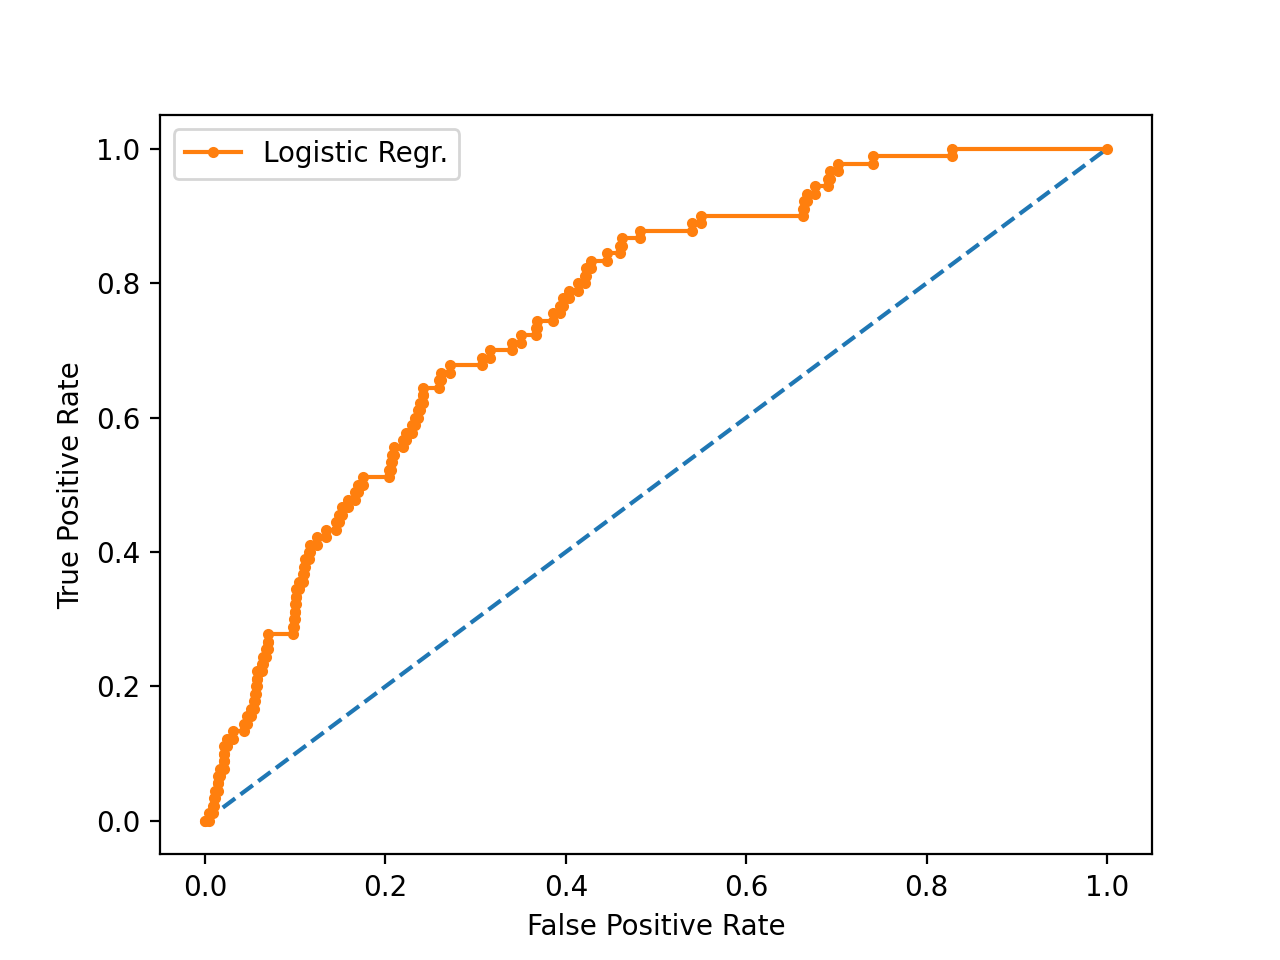

In [16]:
%matplotlib qt


noskill_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
lr_fpr, lr_tpr, threshold_array = roc_curve(y_test, clf_w_best_params.predict_proba(X_test_sc)[:,1])

y_pred_new = lr_tpr>0

logisticRegr_auc = roc_auc_score(y_test, y_probs)
print('Logistic: ROC AUC=%.3f' % (logisticRegr_auc))

plt.figure()
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regr.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# # show the legend
plt.legend()
# # show the plot
plt.show()

In [11]:
# Looking at ROC curve, a TPR of 0.88 and FPR of 0.48 seems reasonable because the prophylaxis may
# cause bleeding, but VTE is deadly, too. Get the threshold at this level
fpr_tpr_thresh = pd.DataFrame({'fpr': lr_fpr, 'tpr': lr_tpr, 'thresh': threshold_array})
fpr_tpr_thresh = fpr_tpr_thresh[(fpr_tpr_thresh['tpr'] < 0.88) & (fpr_tpr_thresh['tpr'] > 0.87)]
print(fpr_tpr_thresh)

          fpr       tpr    thresh
159  0.481758  0.877778  0.002219
160  0.539398  0.877778  0.001989


In [12]:
fpr_tpr_thresh

,fpr,tpr,thresh
159,0.481758,0.877778,0.002219
160,0.539398,0.877778,0.001989


In [13]:
Xt = X_test_sc
yt = y_test

THRESHOLD = [0.0017, 0.0018, 0.0019, 0.0020, 0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026, 0.0027]
for thresh in THRESHOLD:
    print('-----------------')
    print('THRESHOLD =  ' + str(thresh))
    y_pred_thresh = np.where(clf_w_best_params.predict_proba(Xt)[:,1] > thresh, 1, 0)
    acc = accuracy_score(yt, y_pred_thresh)
    print('F1: ' + str(f1_score(yt, y_pred_thresh)))
    print('Precision: ' + str(precision_score(yt, y_pred_thresh)))
    print('Recall: ' + str(recall_score(yt, y_pred_thresh)))
    print(confusion_matrix(yt, y_pred_thresh, normalize='true'))

-----------------
THRESHOLD =  0.0017
F1: 0.00868632707774799
Precision: 0.0043642241379310345
Recall: 0.9
[[0.36637635 0.63362365]
 [0.1        0.9       ]]
-----------------
THRESHOLD =  0.0018
F1: 0.009178470254957508
Precision: 0.004612756264236902
Recall: 0.9
[[0.4006652 0.5993348]
 [0.1       0.9      ]]
-----------------
THRESHOLD =  0.0019
F1: 0.00972447325769854
Precision: 0.004888647474198805
Recall: 0.9
[[0.43464545 0.56535455]
 [0.1        0.9       ]]
-----------------
THRESHOLD =  0.002
F1: 0.009986095310327391
Precision: 0.005021612001017035
Recall: 0.8777777777777778
[[0.46327664 0.53672336]
 [0.12222222 0.87777778]]
-----------------
THRESHOLD =  0.0021
F1: 0.01051021086942061
Precision: 0.0052867563407615606
Recall: 0.8777777777777778
[[0.49033054 0.50966946]
 [0.12222222 0.87777778]]
-----------------
THRESHOLD =  0.0022
F1: 0.011012755279849447
Precision: 0.005541137686750368
Recall: 0.8777777777777778
[[0.5138527  0.4861473 ]
 [0.12222222 0.87777778]]
-------------

# Feature Weights

In [18]:
# Get feature weights and put into dataframe
mydict = {'feature': X_train.columns, 'coef': list(clf_w_best_params.coef_.reshape(-1,1).flatten())}
features_weights = pd.DataFrame(mydict)
features_weights = features_weights.assign(abs_weight=np.abs(features_weights['coef']))
features_weights.head()

,feature,coef,abs_weight
0,age,0.124742,0.124742
1,admissionweight,0.097021,0.097021
2,admissionheight,0.026368,0.026368
3,bmi,0.065130,0.065130
4,gender_Female,-0.008069,0.008069


In [21]:
fw = features_weights.sort_values(by='abs_weight', ascending=False)

In [25]:
fw

,feature,coef,abs_weight
33,heartrate,0.330719,0.330719
26,ima,-0.185345,0.185345
25,activetx,0.179549,0.179549
30,oobintubday1,0.176960,0.176960
0,age,0.124742,0.124742
31,diabetes,-0.113527,0.113527
1,admissionweight,0.097021,0.097021
29,oobventday1,0.096777,0.096777
6,ethnicity_Asian,-0.072596,0.072596
23,immunosuppression,0.069133,0.069133
